In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

In [2]:
subtype1 = pd.read_csv("subtype1/rDNA_subtype1.bwamem2.kmer.hic-mates.bed", sep="\t", names=["target", "start", "stop", "query", "MAPQ", "strand"])
subtype2 = pd.read_csv("subtype2/rDNA_subtype2.bwamem2.kmer.hic-mates.bed", sep="\t", names=["target", "start", "stop", "query", "MAPQ", "strand"])

In [3]:
fai = pd.read_csv("/media/ssd/rita/project/104e/assembly_versions/v3.9_gapfill/v3.9.fasta.fai", sep="\t", header=None, usecols=[0,1], names=["target", "chr_len"])
fai = fai.iloc[0:36, :]
fai["chr_len"] = fai["chr_len"]/1000000

In [4]:
def filter_df(df, hap, mapq=10, read_len=60):
    """
    Filters dataframe from Hi-C mate read alignment bed file. 
    Retains Hi-C mates with MAPQ >= 10 and by haplotype in the target column which can be specified by user.
    Also removes duplicate entries as many continuous k-mers can tag the same read.
    """
    df = df[~df["target"].str.startswith("HiC")].merge(fai, on="target", how="left")
    df = df[df["MAPQ"] >= mapq]
    if hap == "A" or hap == "B":
        df = df[df["target"].str.endswith(hap)]
    elif hap == "AB":
        df = df[(df["target"].str.endswith("A")) | (df["target"].str.endswith("B"))]
    df["haplotype"] = df["target"].str[-1]
    
    df["read_length"] = df["stop"]-df["start"]
    df = df[df["read_length"] >= read_len]
    
    df = df.drop_duplicates(subset="query", keep="first")
    return df

def plot_hicmates(df, hap, chromosome, ax=None):
    """
    creates scatterplot to display mapping position of hic mate for each chromosome.
    """
    df2 = filter_df(df, hap)
    df2 = df2[df2["target"] == chromosome+hap]
    x_values = df2["start"]/1000000
    y_values = df2["MAPQ"]
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 3))
    ax.grid(False)
    if len(df2["chr_len"].tolist()) != 0:
        ax.set_xlim(0, df2["chr_len"].tolist()[0]) #-1000 to allow the entire dot to be shown at edge
    else:
        ax.set_xlim(0, fai.loc[fai["target"] == "chr15A", "chr_len"].values[0])
    ax.set_ylim(0, 65)
    ax.set_xticklabels([])
    ax.scatter(x_values, y_values, alpha=0.4, color="black")
    if ax is None:
        plt.show()

def read_kmer_bed(path):
    return pd.read_csv(path, sep="\t", names=["target", "start", "stop", "query", "MAPQ", "strand"])

In [5]:
# filter both subtype 1 and 2 tables by MAPQ and duplicates 
subtype1ab = filter_df(subtype1, "AB")
subtype1ab["subtype"] = "subtype1"
subtype2ab = filter_df(subtype2, "AB")
subtype2ab["subtype"] = "subtype2"
subtypes = pd.concat([subtype1ab, subtype2ab]).drop_duplicates(subset="query", keep=False) 
subtypes["subtype_hap"] = subtypes["subtype"]+subtypes["haplotype"]
subtypes

,target,start,stop,query,MAPQ,strand,chr_len,haplotype,read_length,subtype,subtype_hap
53,chr12B,3706771,3706876,A01587:281:GW2211252635th:2:1102:14172:16141,60,-,3.979749,B,105,subtype1,subtype1B
125,chr4A,1555399,1555549,A01587:281:GW2211252635th:2:1102:26042:15655,41,+,5.342482,A,150,subtype1,subtype1A
357,chr7B,4007280,4007430,A01587:281:GW2211252635th:2:1103:7437:31062,41,+,4.614849,B,150,subtype1,subtype1B
553,chr6B,1290701,1290789,A01587:281:GW2211252635th:2:1105:17942:13777,60,-,4.902023,B,88,subtype1,subtype1B
594,chr13B,1727698,1727848,A01587:281:GW2211252635th:2:1105:28411:7639,60,+,3.242360,B,150,subtype1,subtype1B
...,...,...,...,...,...,...,...,...,...,...,...
674119,chr7A,2193661,2193763,A01587:281:GW2211252635th:2:2674:21938:36605,50,+,4.748483,A,102,subtype2,subtype2A
676351,chr11A,2786977,2787127,A01587:281:GW2211252635th:2:2677:2926:33489,60,-,4.240573,A,150,subtype2,subtype2A
676352,chr13A,2104249,2104381,A01587:281:GW2211252635th:2:2677:30327:29684,33,-,3.381678,A,132,subtype2,subtype2A
676447,chr8A,4080951,4081081,A01587:281:GW2211252635th:2:2677:5231:32878,30,-,4.713886,A,130,subtype2,subtype2A


In [6]:
# non subtype-specific kmer control
control = pd.read_csv("unspecific/rDNA_unspecific.bwamem2.kmer.hic-mates.bed", sep="\t", names=["target", "start", "stop", "query", "MAPQ", "strand"])
control

,target,start,stop,query,MAPQ,strand
0,chr13A,1924520,1924658,A01587:281:GW2211252635th:2:1101:10013:16955,0,+
1,chr13A,1924951,1925101,A01587:281:GW2211252635th:2:1101:10013:16955,0,-
2,chr13A,1934231,1934369,A01587:281:GW2211252635th:2:1101:10013:16955,0,+
3,chr13A,1978050,1978200,A01587:281:GW2211252635th:2:1101:10013:16955,0,-
4,chr13A,1987761,1987911,A01587:281:GW2211252635th:2:1101:10013:16955,0,-
...,...,...,...,...,...,...
15627991,chr13B,1901249,1901325,A01587:281:GW2211252635th:2:2678:9869:6370,0,+
15627992,chr13B,1901249,1901396,A01587:281:GW2211252635th:2:2678:9869:6370,0,-
15627993,chr13B,1905330,1905404,A01587:281:GW2211252635th:2:2678:9869:6370,0,-
15627994,chr13B,1910595,1910671,A01587:281:GW2211252635th:2:2678:9869:6370,0,+


In [7]:
controldf = filter_df(control, "AB")
controldf["subtype"] = "control"
controldf["subtype_hap"] = "control"+controldf["haplotype"]
controldf

,target,start,stop,query,MAPQ,strand,chr_len,haplotype,read_length,subtype,subtype_hap
53,chr12A,3993175,3993314,A01587:281:GW2211252635th:2:1101:10484:1297,60,+,4.193085,A,139,control,controlA
205,chr8B,2397010,2397160,A01587:281:GW2211252635th:2:1101:11433:29590,20,+,4.606998,B,150,control,controlB
260,chr9B,3880377,3880527,A01587:281:GW2211252635th:2:1101:11822:7310,60,+,4.542930,B,150,control,controlB
290,chr12A,3993175,3993314,A01587:281:GW2211252635th:2:1101:12129:1485,60,+,4.193085,A,139,control,controlA
365,chr9B,3880377,3880527,A01587:281:GW2211252635th:2:1101:13087:18615,60,+,4.542930,B,150,control,controlB
...,...,...,...,...,...,...,...,...,...,...,...
15623751,chr13B,2394175,2394290,A01587:281:GW2211252635th:2:2678:31738:19914,48,-,3.242360,B,115,control,controlB
15625393,chr7A,4252340,4252439,A01587:281:GW2211252635th:2:2678:5330:36839,24,-,4.748483,A,99,control,controlA
15626487,chr5A,2436912,2436985,A01587:281:GW2211252635th:2:2678:7509:13213,55,-,5.228959,A,73,control,controlA
15627044,chr5A,4365755,4365905,A01587:281:GW2211252635th:2:2678:8467:8923,60,+,5.228959,A,150,control,controlA


In [8]:
def filter_duplicates_by_subtype_specificity(group):
    if len(group) > 1:
        return group[group["subtype"].str.startswith("subtype")]

# if a read is tagged by both control and subtype-specific k-mer, mark it as specific.
# This is because a read can cover both non-overlapping k-mer and subtype-specific k-mer. harbouring specific k-mer makes it specific.
df = pd.concat([subtypes, controldf])

# group rows by query. duplicates will have group length >1. if so, apply the filter_duplicates_by_subtype_specificity function to discard row that is tagged by control k-mer.
# this line ignores non-duplicates.
filt_dups_df = df.groupby("query").apply(filter_duplicates_by_subtype_specificity).reset_index(drop=True)

# now have another df for non-duplicates only.
nondups_df = df[~df["query"].duplicated(keep=False)]

# concatenate filtered duplicates and non-dups together. 
filtdf = pd.concat([filt_dups_df, nondups_df]).sort_values(by="haplotype")

In [20]:
filtdf[(filtdf["subtype"]=="subtype1")]["haplotype"].value_counts()
# A: 5.7%
# B: 94.3%

haplotype
B    929
A     56
Name: count, dtype: int64

In [21]:
filtdf[filtdf["subtype"]=="subtype2"]["haplotype"].value_counts()
# A: 90.2%
# B: 9.8%

haplotype
A    1798
B     195
Name: count, dtype: int64

In [22]:
filtdf[filtdf["subtype"]=="control"]["haplotype"].value_counts()
# A: 51.6%
# B: 48.4%

haplotype
B    19094
A    17925
Name: count, dtype: int64

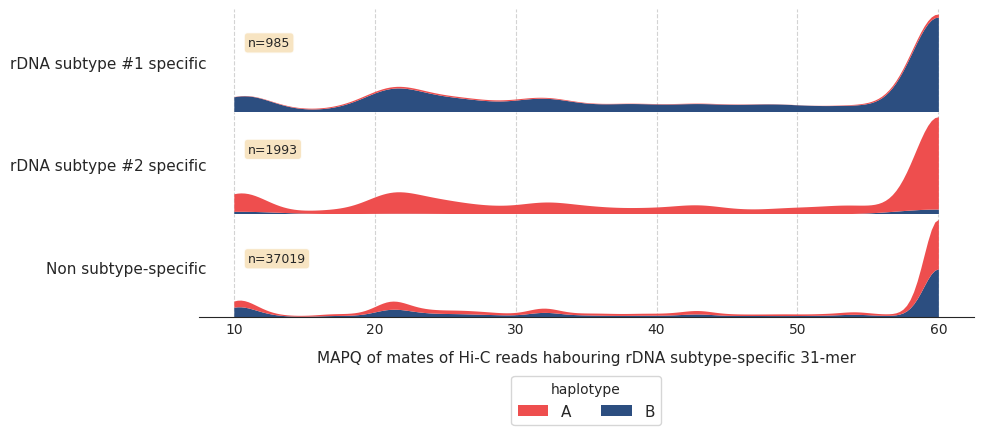

In [10]:
sns.set_style("white")
color=["#ee4e4e", "#2c4e80"]value_countse = {"A": color[0], "B": color[1]}
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 4), sharex=True, sharey=False)
sns.kdeplot(data=filtdf[filtdf["subtype"]=="subtype1"], x="MAPQ", hue="haplotype", bw_adjust=.4, \
            ax=ax[0], palette=palette, fill=True, linewidth=0, alpha=1, cut=0, multiple="stack")
sns.kdeplot(data=filtdf[filtdf["subtype"]=="subtype2"], x="MAPQ", hue="haplotype", bw_adjust=.4, \
            ax=ax[1], palette=palette, fill=True, linewidth=0, alpha=1, legend=None, cut=0, multiple="stack")
sns.kdeplot(data=filtdf[filtdf["subtype"]=="control"], x="MAPQ", hue="haplotype", bw_adjust=.4, \
            ax=ax[2], palette=palette, fill=True, linewidth=0, alpha=1, legend=None, cut=0, multiple="stack")
sns.move_legend(ax[0], "upper center", bbox_to_anchor=(0.5,-2.5), fontsize=11, ncol=2)

for axis in ax:
    for spine in axis.spines.values():
        spine.set_visible(False)
plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[1].get_xticklabels(), visible=False)
plt.setp(ax[0].get_yticklabels(), visible=False)
plt.setp(ax[1].get_yticklabels(), visible=False)
plt.setp(ax[2].get_yticklabels(), visible=False)

ax[0].tick_params(axis='both', length=0)
ax[0].set_ylabel("rDNA subtype #1 specific", rotation=0, labelpad=65, y=0.4, fontsize=11)

ax[1].tick_params(axis='both', length=0)
ax[1].set_ylabel("rDNA subtype #2 specific", rotation=0, labelpad=65, y=0.4, fontsize=11)

ax[2].tick_params(axis='both', length=0)
ax[2].set_ylabel("Non subtype-specific", rotation=0, labelpad=52, y=0.4, fontsize=11)
ax[2].set_xlabel("MAPQ of mates of Hi-C reads habouring rDNA subtype-specific 31-mer",labelpad=10, fontsize=11)
ax[2].spines['bottom'].set_visible(True)

# add text box to show number of aligned Hi-C mates MAPQ>10
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8, linewidth=1)
ax[0].text(11,0.065,f"n={len(filtdf[filtdf['subtype']=='subtype1'])}", fontsize=9, bbox=props)
ax[1].text(11,0.065,f"n={len(filtdf[filtdf['subtype']=='subtype2'])}", fontsize=9, bbox=props)
ax[2].text(11,0.1,f"n={len(filtdf[filtdf['subtype']=='control'])}", fontsize=9,bbox=props)


ax[0].grid(axis='x', linestyle='dashed', color='lightgrey')
ax[1].grid(axis='x', linestyle='dashed', color='lightgrey')
ax[2].grid(axis='x', linestyle='dashed', color='lightgrey')
#plt.tight_layout()
plt.subplots_adjust(hspace=0)
#plt.savefig("rDNA_subtype_HiCmate_MAPQ.svg", format="svg", dpi=600, bbox_inches="tight")

### try ridge plot

<Axes: xlabel='MAPQ', ylabel='Count'>

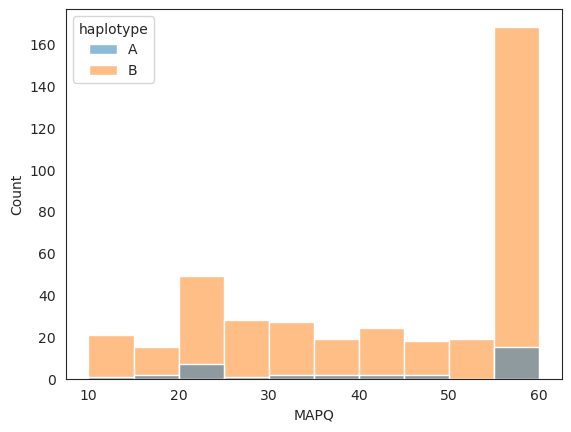

In [137]:
sns.histplot(data=filtdf[filtdf["subtype"]=="subtype1"], x="MAPQ", hue="haplotype")#, bw_adjust=.4, \
            #ax=ax[0], palette=palette, fill=True, linewidth=0, alpha=1, cut=0, multiple="stack")

In [135]:
filtdf

,target,start,stop,query,MAPQ,strand,chr_len,haplotype,read_length,subtype,subtype_hap
0,chr3A,5019854,5019965,A01587:281:GW2211252635th:2:1101:15727:12790,35,-,5.373060,A,111,subtype2,subtype2A
876928,chr17A,1956603,1956753,A01587:281:GW2211252635th:2:2460:23936:13228,32,+,2.836657,A,150,control,controlA
876929,chr17A,1956774,1956904,A01587:281:GW2211252635th:2:2638:23348:18944,40,+,2.836657,A,130,control,controlA
876930,chr17A,1956774,1956904,A01587:281:GW2211252635th:2:2638:23674:18756,40,+,2.836657,A,130,control,controlA
876945,chr17A,1968009,1968159,A01587:281:GW2211252635th:2:1244:19533:3443,60,-,2.836657,A,150,control,controlA
...,...,...,...,...,...,...,...,...,...,...,...
883785,chr18B,1113840,1113990,A01587:281:GW2211252635th:2:2126:32136:19445,60,-,2.651906,B,150,control,controlB
883786,chr18B,1113840,1113990,A01587:281:GW2211252635th:2:2126:32244:23234,60,-,2.651906,B,150,control,controlB
883791,chr18B,1127268,1127402,A01587:281:GW2211252635th:2:1453:24876:13135,60,+,2.651906,B,134,control,controlB
883793,chr18B,1127268,1127402,A01587:281:GW2211252635th:2:1461:21386:15671,60,+,2.651906,B,134,control,controlB


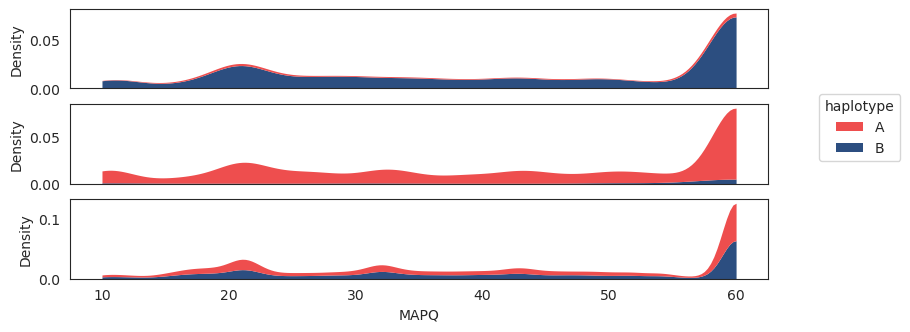

In [134]:
sns.set_style("white")
color=["#ee4e4e", "#2c4e80"]
palette = {"A": color[0], "B": color[1]}
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(9, 3.5), sharex=True, sharey=False)
sns.kdeplot(data=filtdf[filtdf["subtype"]=="subtype1"], x="MAPQ", hue="haplotype", bw_adjust=.4, \
            ax=ax[0], palette=palette, fill=True, linewidth=0, alpha=1, cut=0, multiple="stack")
sns.kdeplot(data=filtdf[filtdf["subtype"]=="subtype2"], x="MAPQ", hue="haplotype", bw_adjust=.4, \
            ax=ax[1], palette=palette, fill=True, linewidth=0, alpha=1, legend=None, cut=0, multiple="stack")
sns.kdeplot(data=filtdf[filtdf["subtype"]=="control"], x="MAPQ", hue="haplotype", bw_adjust=.4, \
            ax=ax[2], palette=palette, fill=True, linewidth=0, alpha=1, legend=None, cut=0, multiple="stack")
sns.move_legend(ax[0], "lower right", bbox_to_anchor=(1.2,-1))

In [117]:
filtdf[(filtdf["subtype"]=="subtype2")&(filtdf["MAPQ"]>=50)]["subtype_hap"].value_counts()

subtype_hap
subtype2A    360
subtype2B     37
Name: count, dtype: int64

In [119]:
filtdf[(filtdf["subtype"]=="control")&(filtdf["MAPQ"]>=10)]["subtype_hap"].value_counts()

subtype_hap
controlB    8569
controlA    8552
Name: count, dtype: int64

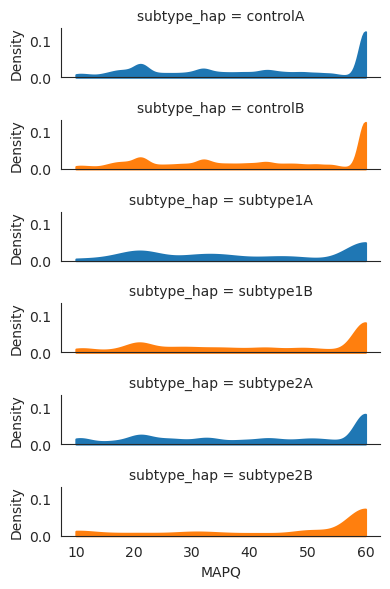

In [165]:
g = sns.FacetGrid(filtdf, row="subtype_hap", hue="haplotype", aspect=4, height=1)
g.map(sns.kdeplot, "MAPQ",  bw_adjust=.4, clip_on=False, fill=True, alpha=1, linewidth=1.5, cut=0)

#### ridge plot version

#### extra: show mapping locations of Hi-C mates. won't be used in publication

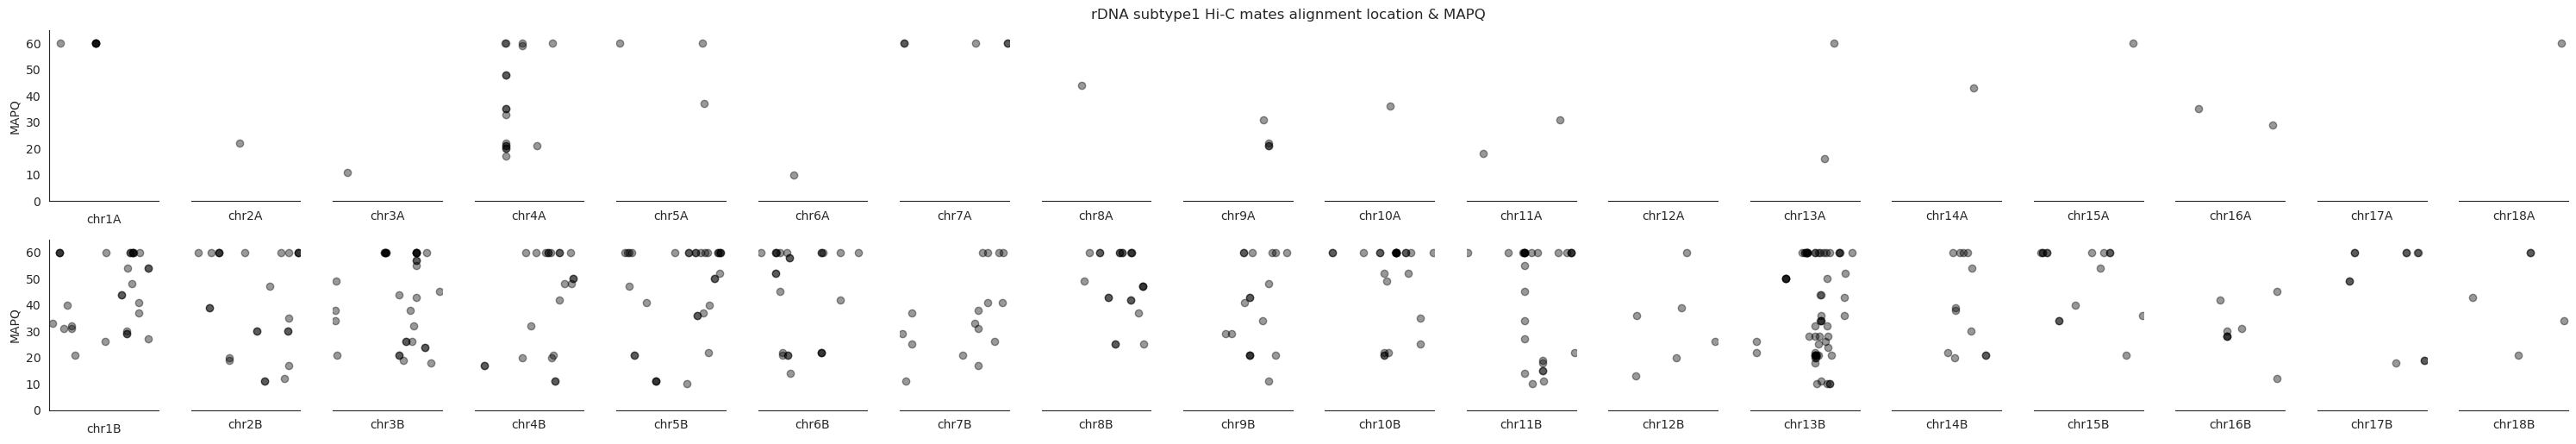

In [349]:
fig, axes = plt.subplots(nrows=2, ncols=18, figsize=(30, 5), sharey="row")

for idx, hap in enumerate(["A", "B"]):
    for chromosome in ["chr"+str(n) for n in range(1, 19)]:
        ax = axes[idx, int(chromosome[3:]) - 1]  # Select the appropriate subplot
        plot_hicmates(subtype1, hap, chromosome, ax)
        ax.set_xlabel(chromosome+hap)
        ax.tick_params(axis='x', which='both', bottom=False, top=False)  # Hide x-axis ticks
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        if chromosome == "chr1":
            ax.set_ylabel("MAPQ")
            ax.spines['left'].set_visible(True)
        else:
            ax.set_ylabel("")
            ax.tick_params(axis='both', which='both', length=0, bottom=False, top=False, left=False, right=False)  # Hide ticks
            ax.spines['left'].set_visible(False)
        
plt.tight_layout()  # Ensure proper spacing between subplots
plt.suptitle("rDNA subtype1 Hi-C mates alignment location & MAPQ", y=1.02)
plt.subplots_adjust(wspace=0.3)
plt.show()

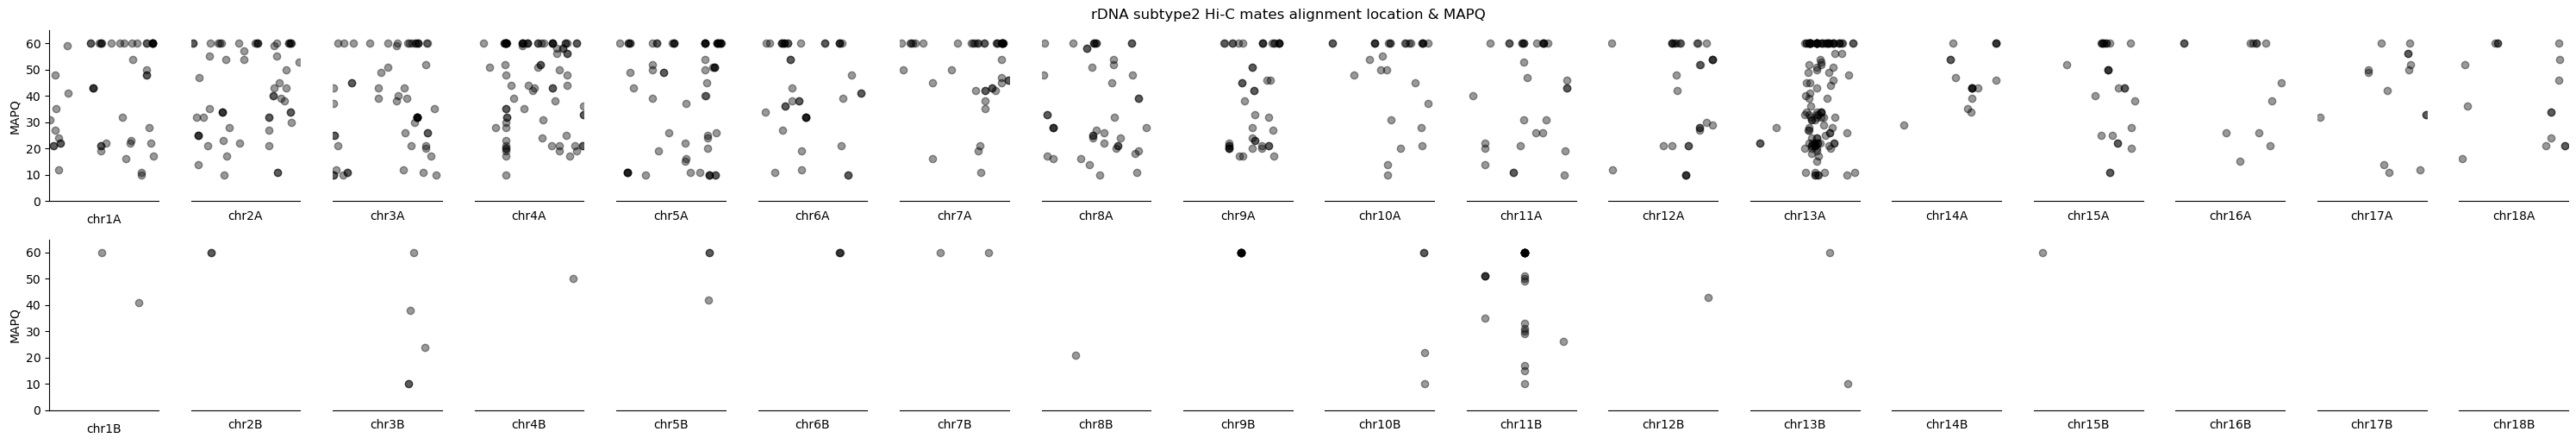

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=18, figsize=(30, 5), sharey="row")

for idx, hap in enumerate(["A", "B"]):
    for chromosome in ["chr"+str(n) for n in range(1, 19)]:
        ax = axes[idx, int(chromosome[3:]) - 1]  # Select the appropriate subplot
        plot_hicmates(subtype2, hap, chromosome, ax)
        ax.set_xlabel(chromosome+hap)
        ax.tick_params(axis='x', which='both', bottom=False, top=False)  # Hide x-axis ticks
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        if chromosome == "chr1":
            ax.set_ylabel("MAPQ")
            ax.spines['left'].set_visible(True)
        else:
            ax.set_ylabel("")
            ax.tick_params(axis='both', which='both', length=0, bottom=False, top=False, left=False, right=False)  # Hide ticks
            ax.spines['left'].set_visible(False)
        
plt.tight_layout()  # Ensure proper spacing between subplots
plt.suptitle("rDNA subtype2 Hi-C mates alignment location & MAPQ", y=1.02)
plt.subplots_adjust(wspace=0.3)
plt.show()